# Первое задание
### Описание даннных
- localUserId — идентификатор пользователя (уникальный браузер)  
- cmUserId  идентификатор зарегестрированного пользователя (уникальный аккаунт)  
- dateTime — дата события
- utm_campaign — название кампании 
- utm_source — источник трафика 
- utm_medium — название типа кампании 
- initReferrer - сайт, с которого пользователь совершил переход на profeat.site
- os — операционная система пользователя 
- browser — браузер пользователя 
- blockid — уникальный идентификатор блока, из которых состоит сайт, с которым произошло событие; тип блока содержится в названии события
- event — произошедшее событие

Приходит к вам продакт   и говорит: “Теперь мы будем работать над активацией пользователей! Для этого мне нужен борд с основной воронкой продукта: от попадания  пользователя на лендинг до оплаты. Он будет мне нужен, чтобы смотреть основные конверсии продукта, основные этапы такие: 
1. Переход на лэндинг
2. Регистрация 
3. Добавление первого блока 
4. Попытка оплаты
5. Покупка платного тарифа 
Фильтры нужны по датам, по операционной системе и... почему-нибудь еще, посмотри, может быть там будет что-то полезное”. После чего он говорит, что у него интервью с пользователями и убегает.  

## Первый взгляд на данные

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import re

In [2]:
df = pd.read_csv('C:\\Users\\admin\\Documents\\Project Python\\WAzzUP test\\profeat-data-for-assignment.csv')

In [3]:
df.head()

,localUserId,cmUserId,dateTime,utm_source,utm_medium,utm_campaign,initReferrer,browser,os,event,blockid
0,3f2fa233-444b-4e87-a5c4-0277499c4be4,NaN,2022-04-15 15:26:13.049 UTC,NaN,NaN,NaN,NaN,NaN,NaN,landing.unique-visit,NaN
1,3f2fa233-444b-4e87-a5c4-0277499c4be4,NaN,2022-04-15 00:00:00.076 UTC,NaN,NaN,NaN,NaN,Chrome,NaN,landing.unique-visit,NaN
2,454e934d-f554-4e19-be36-03d1ce201413,NaN,2022-04-15 11:04:56.571 UTC,NaN,NaN,NaN,NaN,Firefox,Ubuntu,landing.unique-visit,NaN
3,328e7e92-b284-4dfe-ab76-c6443f3d13e0,621f862dddf4bc00444bbb0c,2022-04-15 11:35:58.98 UTC,NaN,NaN,NaN,https://contact-me.info/,Firefox,Ubuntu,editor.add.click,NaN
4,328e7e92-b284-4dfe-ab76-c6443f3d13e0,621f862dddf4bc00444bbb0c,2022-04-15 11:36:11.811 UTC,NaN,NaN,NaN,https://contact-me.info/,Firefox,Ubuntu,editor.add.click,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53958 entries, 0 to 53957
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   localUserId   53958 non-null  object
 1   cmUserId      40667 non-null  object
 2   dateTime      53958 non-null  object
 3   utm_source    40674 non-null  object
 4   utm_medium    28137 non-null  object
 5   utm_campaign  28147 non-null  object
 6   initReferrer  49623 non-null  object
 7   browser       53896 non-null  object
 8   os            53853 non-null  object
 9   event         53958 non-null  object
 10  blockid       8543 non-null   object
dtypes: object(11)
memory usage: 4.5+ MB


In [5]:
df = df.rename(columns={'localUserId':'local_us_id',
                'cmUserId':'reg_us_id',
                'initReferrer':'init_referrer',
                'dateTime':'dt'})

## Предобработка данных
### Дата и ID

In [6]:
# Посмотрим к каким ивентам относятся пользователи без регистрационого id
df[df['reg_us_id'].isna()]['event'].value_counts()

landing.unique-visit    7564
register-enter          5727
Name: event, dtype: int64

Это пользователи которые перешли на сайт, некторые из них начали регистрацию, но никто не закончил

In [7]:
print('Количество зарегистрированных ID:', len(df['reg_us_id'].unique()))
print('Количество локальных ID:', len(df['local_us_id'].unique()))   

Количество зарегистрированных ID: 2422
Количество локальных ID: 10248


In [8]:
# Приведем колонку к нужному типу и уберем часовые пояса и микросекунды
df['dt'] = pd.to_datetime(df['dt']).dt.tz_localize(None).apply(lambda x: x.replace(microsecond=0))
# Создадим дополнительный столбцы с датой и временем
df['date'] = df['dt'].dt.date
df['time'] = df['dt'].dt.time

In [9]:
df['utm_source'].unique()

array([nan, 'yandex', 'visitka', 'wazzup', '404', 'google', 'vk',
       'telegram', 'mytarget', 'instagram', 'aDqCFY', 'vkontakte',
       'yandex_poisk', 'waba'], dtype=object)

### Источник трафика

In [10]:
df['utm_source'].unique()

array([nan, 'yandex', 'visitka', 'wazzup', '404', 'google', 'vk',
       'telegram', 'mytarget', 'instagram', 'aDqCFY', 'vkontakte',
       'yandex_poisk', 'waba'], dtype=object)

In [11]:
df['utm_source'].value_counts()

yandex          26387
visitka         10947
wazzup           1199
google            802
mytarget          651
404               381
telegram          283
instagram           8
vk                  6
yandex_poisk        4
waba                4
aDqCFY              1
vkontakte           1
Name: utm_source, dtype: int64

- Выставим значение заглушку для не определенных названий, такаже необходимо заменить 404 и aDqCFY на заглушку
- Заменим yandex_poisk на yandex, а vk на vkontakte

In [12]:
df['utm_source'] = df['utm_source'].fillna('unknow')
df.loc[(df['utm_source'] == 'aDqCFY') | (df['utm_source'] == '404'), 'utm_source'] = 'unknow'
df.loc[df['utm_source'] == 'yandex_poisk', 'utm_source'] = 'yandex'
df.loc[df['utm_source'] == 'vk', 'utm_source'] = 'vkontakte'

### Название и тип компании

In [13]:
df['utm_medium'].unique()

array([nan, 'cpc', 'reklama', 'post', 'ILz', 'public'], dtype=object)

In [14]:
# Также выставим значение заглушку

In [15]:
df['utm_source'].value_counts()

yandex       26391
unknow       13666
visitka      10947
wazzup        1199
google         802
mytarget       651
telegram       283
instagram        8
vkontakte        7
waba             4
Name: utm_source, dtype: int64

In [16]:
df['utm_medium'] = df['utm_medium'].fillna('unknow')

In [17]:
df['utm_campaign'].unique()

array([nan, '71648929', '72411577', '72412884', '72412889', '72412683',
       '72972241', '72984477',
       'cid|13244953096|0521|google|cpc|ru|teplye|multissylka',
       '71838068', 'smognails', '72411876',
       'cid|13815939800|0521|google|cpc|eu|competitors|taplink|cena',
       '69739018',
       'cid|13322676845|0521|google|cpc|by|teplye|multissylka',
       '74305653', 'i_nstagramer', '52150546', '52150845', '52151040',
       '62012165', '63466135', '72482736', '72482737', '72482739',
       '72482740', '72482741',
       'cid|13322676851|0521|google|cpc|kz|teplye|multissylka',
       'cid|13244871763|0521|google|cpc|ru|tranzak|besplatno|sch',
       'cid|13824314847|0721|google|cpc|ru|teplye_2|instalanding',
       'cid|13815939800|0521|google|cpc|eu|competitors|taplink|for_social',
       'cid|13813036738|0521|google|cpc|by|competitors|taplink|for_social',
       '62012011',
       'cid|13811038492|0521|google|cpc|kz|competitors|taplink|sdelat',
       '0721|instagram_cpc

Не совсем понятный для меня набор данных, cid насколько я понял это идентификатор компании, можно распарсить строчки и вынуть все айдишники, и если бы был словарь, я заменил бы их на названия компаний, чтобы добавить фильтр на дашборд, но словаря нет, поэтому столбец просто удалю.

### Сайт перехода

In [18]:
df['init_referrer'].head(10)

0                         NaN
1                         NaN
2                         NaN
3    https://contact-me.info/
4    https://contact-me.info/
5    https://contact-me.info/
6                         NaN
7                         NaN
8                         NaN
9                         NaN
Name: init_referrer, dtype: object

In [19]:
# Сделаем сайты более читабельными
def site_replace(string):
    if pd.isna(string):
        return 'unknow'
    elif 'contact-me' in string: 
        return 'organic'
    else:
        return re.findall(r'//.*/', string)[0].replace('/', '')

In [20]:
len(df['init_referrer'].apply(site_replace).unique())

272

Значений очень много, даже после обработки, удобный фильтр сделать не получится, колонка под удаление

### Браузер и операционная система

In [21]:
df['browser'].unique()

array([nan, 'Chrome', 'Firefox', 'Yandex', 'Instagram', 'Opera Touch',
       'Mobile Safari', 'WebKit', 'GSA', 'Opera', 'Safari',
       'MIUI Browser', 'Chrome WebView', 'Samsung Browser', 'Facebook',
       'Edge', 'Quark', 'QQBrowser', 'Android Browser', 'UCBrowser',
       'Chrome Headless', 'Silk', 'Waterfox', 'Whale'], dtype=object)

Не понимаю специфику привлечения пользователей, есть ли какие-либо различия в пользователях, которые пользуются разными браузерами. В работе я бы обязательно уточнил этот момент у коллег. Пока интуитивно предоположу что нет, фильтр в дашборде  делать не будем, столбец под удаление.

In [22]:
df['os'].unique()

array([nan, 'Ubuntu', 'iOS', 'Linux', 'Mac OS', 'Android', 'Windows',
       'Chromium OS', 'Fedora'], dtype=object)

In [23]:
# Установим заглушку
df['os'] = df['os'].fillna('unknow')

### Ивенты

In [24]:
df['event'].unique()

array(['landing.unique-visit', 'editor.add.click', 'payment.unsubscribe',
       'register-confirm-code-success', 'editor-bg.save.click',
       'editor-main.save.click', 'register-enter', 'editor.link.click',
       'editor-messengers.save.click', 'editor-title.save.click',
       'editor-socials.save.click', 'editor-photos.save.click',
       'editor-separator.save.click', 'editor-button.save.click',
       'payment.attempt', 'editor-price.save.click',
       'editor-add.payment.click', 'editor-map.save.click',
       'editor-description.save.click', 'editor-payment.cancel.click',
       'editor-faq.save.click', 'editor-products.save.click',
       'editor-messengers.delete.click', 'editor-socials.delete.click',
       'editor-description.delete.click', 'editor-title.delete.click',
       'editor-photos.delete.click', 'editor-main.delete.click',
       'editor-button.delete.click', 'editor-reviews.save.click',
       'editor-banner.save.click', 'editor-payment.save.click',
       'pa

Очень много ивентов, большинтво связаны именно с добовлением новых блоков, для дашборда нужно только 5:
1. Переход на лэндинг (landing.unique-visit)
2. Регистрация (register-confirm-code-success)
3. Добавление первого блока (editor.add.click)
4. Попытка оплаты (payment.attempt)
5. Покупка платного тарифа (payment.success)

Также в важных событиях есть: Клик по Ссылка editor.link.click - что за ссылка не понятно. Пошел на сайт: возможно имеется в виду ссылка в нижнем меню, к заданой воронке она не относится, добавлять не будем.

In [25]:
# Создаем список нужных ивентов, остальные удалим из датафрейма
event_list = ['landing.unique-visit', 'register-confirm-code-success', 'editor.add.click',
              'payment.attempt', 'payment.success']
df2 = df[df['event'].isin(event_list)]

In [26]:
df2['blockid'].unique() # Тоже под удаление

array([nan], dtype=object)

**Последние исправления**

In [27]:
# Удалим ненужные столбцы
df2 = df2.drop(columns=['utm_campaign', 'browser', 'blockid', 'init_referrer'], axis=1)

In [28]:
print('Количество дубликатов:', df2.duplicated().sum())

Количество дубликатов: 83


In [29]:
df2 = df2.drop_duplicates()
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21772 entries, 0 to 53938
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   local_us_id  21772 non-null  object        
 1   reg_us_id    14268 non-null  object        
 2   dt           21772 non-null  datetime64[ns]
 3   utm_source   21772 non-null  object        
 4   utm_medium   21772 non-null  object        
 5   os           21772 non-null  object        
 6   event        21772 non-null  object        
 7   date         21772 non-null  object        
 8   time         21772 non-null  object        
dtypes: datetime64[ns](1), object(8)
memory usage: 1.7+ MB


In [30]:
df2['event'].value_counts()

editor.add.click                 12016
landing.unique-visit              7622
register-confirm-code-success     1926
payment.attempt                    189
payment.success                     19
Name: event, dtype: int64

## Исследовательский анализ данных

### Дата

In [31]:
min_d = df2['date'].min()
max_d = df2['date'].max()
print('Минимальная дата', min_d)
print('Максимальная дата', max_d)
dates = pd.date_range(start=min_d, end=max_d)
print('Изучаем данные за период {} дней'.format(len(dates)))

Минимальная дата 2022-04-01
Максимальная дата 2022-05-01
Изучаем данные за период 31 дней


ГИСТОГРАММА КОЛИЧЕСТВА ПЕРЕХОДОВ НА ЛЕНДИНГ ДНЯМ


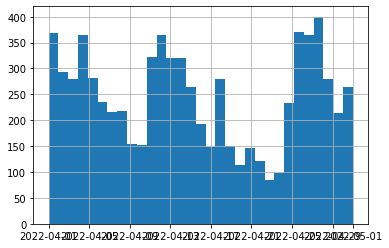

In [32]:
df2[df2['event'] == 'landing.unique-visit']['date'].hist(bins=31)
print('ГИСТОГРАММА КОЛИЧЕСТВА ПЕРЕХОДОВ НА ЛЕНДИНГ ДНЯМ')

Видим что выгрузка данных очень неравномерная, возможно это связано с особенностями привлечения по рекламным источникам. Главное, мы убедились, что нет совсем пустых дней и выгрузка подходит для дальнейшего анализа.

### Фильтр активации

Выясним по имеющимся данным, какое среднее количество блоков находится у пользователя в момент  оплаты.

In [33]:
def event_status(row):
    if pd.isna(row):
        return 0
    else:
        if 'save' in row:
            return 1
        elif 'delete' in row:
            return -1
        else:
            return 0

In [34]:
df['event_status'] = df['event'].apply(event_status)
payment_user = df[df['event'] == 'payment.success'][['reg_us_id', 'date']]

In [35]:
blocks = 0
for i in payment_user.index:
    blocks += df[(df['reg_us_id'] == payment_user['reg_us_id'][i]) &
                  (df['date'] <= payment_user['date'][i])]['event_status'].sum()
avg_blocks = round(blocks / len(payment_user))
print('Среднее количество блоков у пользователей в момент совершения оплаты:', avg_blocks)

Среднее количество блоков у пользователей в момент совершения оплаты: 29


Теперь сделаем условный флажок для пользователей которые достигли показателей купивших 

In [38]:
# Количество ивентов с накоплением
accum_ev = df.copy()
accum_ev = accum_ev.groupby(['reg_us_id', 'date'])['event_status'].sum().reset_index().rename(columns={'event_status':'cnt_blocks'})
accum_ev.head()

,reg_us_id,date,cnt_blocks
0,603f87ecdd53710023412b94,2022-04-12,0
1,6047c90ba1bc4800239048e2,2022-04-01,1
2,606cc258075eec0022cd3e57,2022-04-01,0
3,606cc258075eec0022cd3e57,2022-04-25,1
4,606cc258075eec0022cd3e57,2022-04-26,2


In [39]:
# Добавим столбец в нужный датафрейм
df2 = df2.merge(accum_ev, on=['reg_us_id', 'date'], how='left')
df2.head()

,local_us_id,reg_us_id,dt,utm_source,utm_medium,os,event,date,time,cnt_blocks
0,3f2fa233-444b-4e87-a5c4-0277499c4be4,NaN,2022-04-15 15:26:13,unknow,unknow,unknow,landing.unique-visit,2022-04-15,15:26:13,NaN
1,3f2fa233-444b-4e87-a5c4-0277499c4be4,NaN,2022-04-15 00:00:00,unknow,unknow,unknow,landing.unique-visit,2022-04-15,00:00:00,NaN
2,454e934d-f554-4e19-be36-03d1ce201413,NaN,2022-04-15 11:04:56,unknow,unknow,Ubuntu,landing.unique-visit,2022-04-15,11:04:56,NaN
3,328e7e92-b284-4dfe-ab76-c6443f3d13e0,621f862dddf4bc00444bbb0c,2022-04-15 11:35:58,unknow,unknow,Ubuntu,editor.add.click,2022-04-15,11:35:58,-8.0
4,328e7e92-b284-4dfe-ab76-c6443f3d13e0,621f862dddf4bc00444bbb0c,2022-04-15 11:36:11,unknow,unknow,Ubuntu,editor.add.click,2022-04-15,11:36:11,-8.0


In [41]:
df2['cnt_blocks'].describe()

count    14268.000000
mean        22.894589
std         27.906993
min        -11.000000
25%          4.000000
50%         13.000000
75%         30.000000
max        145.000000
Name: cnt_blocks, dtype: float64

Появились отрицательные значения, я думаю это переходящие строки с прошлого месяца. В таком случае некоторые ивенты добавления блока, как и ивент регистрации отсутствуют в датафрейме для этих пользователей.

In [ ]:
display(df2[df2['cnt_blocks'] < 20].head())
df2[df2['reg_us_id'] =='617f5f006ba50b004346455c']['event']

Проверка подтвердила предположение, осталось только добавить флажок статуса активации

In [42]:
df2['active_us'] = df2['cnt_blocks'].apply(lambda x: True if x>=avg_blocks else False)

In [43]:
df2[df2['cnt_blocks'] > 20].sample(5)

,local_us_id,reg_us_id,dt,utm_source,utm_medium,os,event,date,time,cnt_blocks,active_us
12615,67744c15-7bea-45da-adab-72113b9b18ee,60d62db5685682004593a298,2022-04-27 17:55:08,unknow,unknow,Android,editor.add.click,2022-04-27,17:55:08,48.0,True
13746,781837fa-4dc9-4159-91b1-b0d095f5cc44,626820e13790540043032db7,2022-04-26 17:46:46,unknow,unknow,iOS,editor.add.click,2022-04-26,17:46:46,23.0,False
18102,824159f8-1d97-4ba7-8e04-a24eb2b8965f,625ece6608dd5000446f397e,2022-04-19 17:28:33,yandex,cpc,Android,editor.add.click,2022-04-19,17:28:33,39.0,True
13981,7f284bba-ee70-4429-ada8-6e41f7cf0d94,62685a5b3790540043038bd4,2022-04-26 21:11:44,yandex,cpc,iOS,editor.add.click,2022-04-26,21:11:44,37.0,True
13979,7f284bba-ee70-4429-ada8-6e41f7cf0d94,62685a5b3790540043038bd4,2022-04-26 21:03:51,yandex,cpc,iOS,editor.add.click,2022-04-26,21:03:51,37.0,True


In [44]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21772 entries, 0 to 21771
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   local_us_id  21772 non-null  object        
 1   reg_us_id    14268 non-null  object        
 2   dt           21772 non-null  datetime64[ns]
 3   utm_source   21772 non-null  object        
 4   utm_medium   21772 non-null  object        
 5   os           21772 non-null  object        
 6   event        21772 non-null  object        
 7   date         21772 non-null  object        
 8   time         21772 non-null  object        
 9   cnt_blocks   14268 non-null  float64       
 10  active_us    21772 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), object(8)
memory usage: 1.8+ MB


### Ивенты

In [45]:
df2['event'].value_counts()

editor.add.click                 12016
landing.unique-visit              7622
register-confirm-code-success     1926
payment.attempt                    189
payment.success                     19
Name: event, dtype: int64

Необходимо убрать лишние ивенты добавления блоков для каждого пользователя и оставить только первый

In [46]:
# Добавляем индексы, чтобы фильтровать нужные строки
df2 = df2.reset_index()
# Ищем индексы для каждого события
ind = df2.sort_values(by='dt').groupby(['local_us_id', 'event']).agg({'index':'first'})
# Фильтруем строки, убирая лишние события
funnel = df2[df2['index'].isin(ind['index'])]
funnel['event'].value_counts()

landing.unique-visit             7423
editor.add.click                 1915
register-confirm-code-success    1891
payment.attempt                   129
payment.success                    18
Name: event, dtype: int64

Помимо ивентов добавления блока, сократились еще ряд других, часть из них повторяющиеся ивенты для одного локального айди, а вот уменьшение в ивенте подтверждения платежа возможно связано с тем, что с одного устройства заходили на разные аккаунты, проверим:

In [47]:
df2[(df2['event'] == 'payment.success') &
    (~df2['reg_us_id'].isin(funnel[funnel['event'] == 'payment.success']['reg_us_id']))]

,index,local_us_id,reg_us_id,dt,utm_source,utm_medium,os,event,date,time,cnt_blocks,active_us
7708,7708,4d59343b-abaa-40b6-b693-f1e7da558b74,62497d7bfeba900044e20ef9,2022-04-03 11:03:30,unknow,unknow,Windows,payment.success,2022-04-03,11:03:30,16.0,False


Подтвердилось, чтобы избежать удаления нужных нам строчек будем группировать отдельно лендинг по локальному айди, и остальные ивенты по регистрационному айди

In [48]:
s1 = (df2[df2['event'] == 'landing.unique-visit'].sort_values(by='dt')
                                             .groupby('local_us_id').agg({'index':'first'}))
s2 = (df2[df2['event'] != 'landing.unique-visit'].sort_values(by='dt')
                                             .groupby(['reg_us_id','event']).agg({'index':'first'}))
ind2 = pd.concat([s1, s2])
funnel_final = df2[df2['index'].isin(ind2['index'])]

In [49]:
funnel_final['event'].value_counts()

landing.unique-visit             7423
register-confirm-code-success    1926
editor.add.click                 1750
payment.attempt                   128
payment.success                    19
Name: event, dtype: int64

In [50]:
funnel_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11246 entries, 2 to 21743
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   index        11246 non-null  int64         
 1   local_us_id  11246 non-null  object        
 2   reg_us_id    3941 non-null   object        
 3   dt           11246 non-null  datetime64[ns]
 4   utm_source   11246 non-null  object        
 5   utm_medium   11246 non-null  object        
 6   os           11246 non-null  object        
 7   event        11246 non-null  object        
 8   date         11246 non-null  object        
 9   time         11246 non-null  object        
 10  cnt_blocks   3941 non-null   float64       
 11  active_us    11246 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(8)
memory usage: 1.0+ MB


Пользователи, у которых отсутствует ивент регистрации при наличии регистрационного кода, являются переходящими строками из предидущего месяца, тогда пользователь зарегистрировался, а сейчас вернулся, чтобы например опять протестировать функционал или купить платный аккаунт, если бы цель была, проанализировать воронку только за этот месяц, я бы их удалил, но по скольку речь про дашборд, в который должны по идее поступать полные данные, мы их оставим.

## Выгружаем датафрейм

Изменим название ивентов, чтобы они были более читабельными 

In [51]:
def ev_name(row):
    if row == 'landing.unique-visit':
        return 'Лендинг'
    elif row == 'register-confirm-code-success':
        return 'Регистрация'
    elif row == 'editor.add.click':
        return 'Добавление первого блока'
    elif row == 'payment.attempt':
        return 'Попытка оплаты'
    else:
        return 'Подтверждение оплаты'  

In [52]:
funnel_final['event'].value_counts()

landing.unique-visit             7423
register-confirm-code-success    1926
editor.add.click                 1750
payment.attempt                   128
payment.success                    19
Name: event, dtype: int64

In [53]:
final = funnel_final.copy(deep=True) 
final['event'] = final['event'].apply(ev_name)
final = final[['utm_source', 'utm_medium', 'os', 'date', 'event', 'active_us']]
final.columns = ['Источник трафика', 'Тип компании', 'ОС', 'Дата', 'Ивент', 'Статус активности']
final['count'] = 1
final.head()

,Источник трафика,Тип компании,ОС,Дата,Ивент,Статус активности,count
2,unknow,unknow,Ubuntu,2022-04-15,Лендинг,False,1
7,unknow,unknow,iOS,2022-04-15,Регистрация,False,1
8,unknow,unknow,iOS,2022-04-15,Регистрация,True,1
9,unknow,unknow,iOS,2022-04-15,Регистрация,False,1
10,unknow,unknow,iOS,2022-04-15,Регистрация,False,1


In [54]:
final.to_csv('final.csv')

## Ответы на вопросы
***Задача:***  Активация пользователей

***Вопросы:*** 

**1. Как вы считаете, если сделать такой дашборд будет ли он полезен и будет ли он отвечать на поставленный вопрос?** 


Активация пользователей сложный процесс, который происходит в большей степени, как мне кажется на этапах перехода от регистрации к пользованию продукта и от использования, к оплате платной подписки в этом плане на воронке визуально будет хоршо видно, какие этапы в какой период времени западают. Также фильтры помогу выявлять подгруппы польлзователей с плохой конверсией и работать над ними. Этап перехода от лендинга к регистрации скорее вопрос изучения рекламных конверсии.


**2. Можно ли его как-то улучшить? Если да, то как?** 


В дальнейшем можно добавить детализацию клиентского опыта взаимодействия с приложением на этапе добавления блоков: какими чаще всего пользуются, какие удаляют - это поможет улучшить продукт. 

## Ссылка на дашборд

https://public.tableau.com/views/FunnelforWazzup/sheet3?:language=en-US&:display_count=n&:origin=viz_share_link

# Второе задание
Напишите SQL запрос, который ответит на вопрос сколько и каких **типов** блоков в среднем находится на сайте в момент оплаты тарифа. Структура таблицы такая же, что в прошлом задании
```
WITH "t1" AS (
SELECT reg_us_id, dt::date AS payment_date
FROM "SQL" s 
WHERE "event" LIKE 'payment.success'),

"t2" AS (
SELECT reg_us_id, dt::date AS event_date, 
       count(CASE WHEN event = 'editor-messengers.save.click' THEN dt::date END) AS mes_save,
       count(CASE WHEN event = 'editor-messengers.delete.click' THEN dt::date END) AS mes_del,
       count(CASE WHEN event = 'editor-socials.save.click' THEN dt::date END) AS soc_save,
       count(CASE WHEN event = 'editor-socials.delete.click' THEN dt::date END) AS soc_del
FROM "SQL" s 
WHERE reg_us_id IS NOT NULL 
GROUP BY reg_us_id, event_date),

"t3" AS (
SELECT t1.payment_date,
       sum(t2.mes_save) - sum(t2.mes_del) AS mes_count,
       sum(t2.soc_save) - sum(t2.soc_del) AS soc_count
FROM "t1" LEFT JOIN "t2" ON t1.reg_us_id=t2.reg_us_id
WHERE t1.payment_date >= t2.event_date
GROUP BY t1.payment_date)

SELECT round(avg(mes_count), 2) AS mes_avg,
       round(avg(soc_count), 2) AS soc_avg,
	   round(avg(mes_count + soc_count), 2) AS total_avg
FROM "t3"
	   
```

Не добавлял все блоки через оператор CASE, чтобы не нагромождать код, продемонстрировал сам способ решения задачи.
Для подсчета использовал столбцы приведенные ниже.

In [55]:
df[~df['reg_us_id'].isna()][['reg_us_id', 'dt', 'event']].head()

,reg_us_id,dt,event
3,621f862dddf4bc00444bbb0c,2022-04-15 11:35:58,editor.add.click
4,621f862dddf4bc00444bbb0c,2022-04-15 11:36:11,editor.add.click
5,621f862dddf4bc00444bbb0c,2022-04-15 11:36:37,payment.unsubscribe
8,6259aeca6a4d5800458f65fc,2022-04-15 17:43:38,register-confirm-code-success
9,6259b2c16a4d5800458f6a7d,2022-04-15 18:00:33,register-confirm-code-success
